In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#INSTALL ON FIRST RUN ON COLABS TO PREVENT INPLACE OPS
!pip3 install torch==1.4.0 torchvision==0.5.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [3]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
from torch.autograd import Variable
torch.autograd.set_detect_anomaly(True)
import random
from torch.utils.data import TensorDataset

[0.50061816 0.50078915 0.50100724 0.50128531 0.50163963 0.5020908
 0.50266478 0.50339418 0.50431971 0.50549198 0.50697327 0.50883952
 0.51118197 0.51410832 0.51774255 0.5222227  0.52769535 0.5343055
 0.54218091 0.55141049 0.5620184  0.57393803 0.58699274 0.60089178
 0.61524788 0.62961699 0.64355275 0.6566617  0.66864509 0.67931864
 0.68860995 0.69653978 0.70319567 0.70870546 0.7132151  0.71687236
 0.71981653 0.72217271 0.7240495  0.72553889 0.72671739 0.72764773
 0.72838084 0.72895769 0.72941109 0.72976714 0.73004655 0.7302657
 0.7304375  0.73057215]


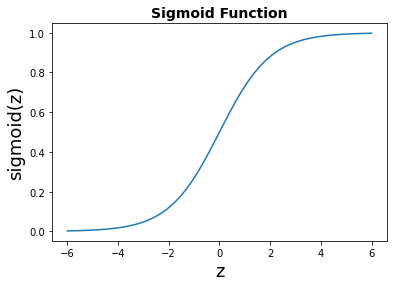

In [4]:
#PRELIMINARY PLOTS/DEFINITIONS

#sigmoid
def sigmoid(z):
  y = np.exp(z)/(1+np.exp(z));
  return y

line = np.linspace(-6, 6, endpoint= True)
sig_z = sigmoid(line)
print(sigmoid(sig_z))
plt.plot(line,sig_z)
plt.title("Sigmoid Function",fontsize=14, fontweight='bold')
plt.xlabel("z",fontsize=18)
plt.ylabel("sigmoid(z)",fontsize=18)
plt.show()

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.12244898 0.36734694 0.6122449  0.85714286 1.10204082
 1.34693878 1.59183673 1.83673469 2.08163265 2.32653061 2.57142857
 2.81632653 3.06122449 3.30612245 3.55102041 3.79591837 4.04081633
 4.28571429 4.53061224 4.7755102  5.02040816 5.26530612 5.51020408
 5.75510204 6.        ]


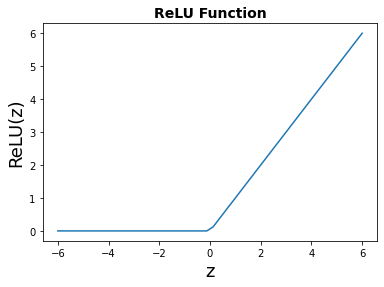

In [5]:
#RELU
def relu(z):
   return np.maximum(0,z)

line = np.linspace(-6, 6, endpoint= True)
relu_z_0 = relu(line)
print(relu(line))
plt.plot(line,relu_z_0)
plt.title("ReLU Function",fontsize=14, fontweight='bold')
plt.xlabel("z",fontsize=18)
plt.ylabel("ReLU(z)",fontsize=18)
plt.show()

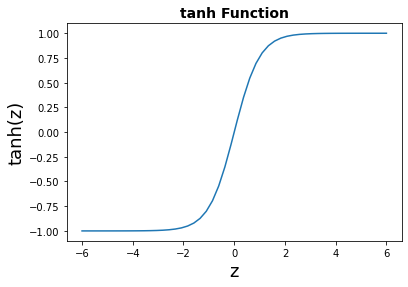

In [6]:
#tanh
line = np.linspace(-6, 6, endpoint= True)
tan_z = np.tanh(line)
plt.plot(line,tan_z)
plt.title("tanh Function",fontsize=14, fontweight='bold')
plt.xlabel("z",fontsize=18)
plt.ylabel("tanh(z)",fontsize=18)
plt.show()

In [35]:
#SET THE GLOBAL PARAMETERS.
#If X[t] represents the Stock Price at Time t. Then Sequence Length is the number of X[t] before we predict the next stock price.
SEQUENCE_LENGTH = 120
NUM_LAYERS = 1# This is set to 1 to prevent over fitting
OUTPUT_SIZE = 1
#HIDDEN_LAYERS = int(SEQUENCE_LENGTH*(0.6667))+OUTPUT_SIZE # See theory on this. We have now experimented for varying 
#hidden layers to determine the best for this model
TRAIN_SPLIT = 0.80 #of all the data we select from the closing prices, this is the test split.
SAMPLE = 0.80 #as a fraction of all the data how much data we want, some will be left for blind testing. 0.1*datalength etc. 
batch_size=256
epoch_delta_limit = 0.00005
flat_loss_count = 5 #when have we converged, when we have been flat for how long?
max_mse = 0.002
min_epochs = 50
# Hyper parameters
learning_rate = 0.00001
num_epochs = 1000

In [8]:
from google.colab import drive
drive.mount('/content/drive')
#drive.mount("/content/drive", force_remount=True)
!ls drive/"My Drive"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Colab Notebooks'
'Edit_Ad_ML_Project (1).ipynb'
 Edit_Ad_ML_Project.ipynb
 MSFT.USUSD_Candlestick_1_M_BID_01.01.2020-02.03.2020.csv
 MSFT.USUSD_Candlestick_1_M_BID_01.01.2020-31.03.2020.csv
 Untitled
'Untitled form.gform'


In [9]:
FileName = "MSFT.USUSD_Candlestick_1_M_BID_01.01.2020-31.03.2020.csv"

#**DATA EXPLORATION | DATA PRE-PROCESSING**
Data is in 1 minute intervals and as can be seen above contains many time periods where there is no trading activity after the exchanges are closed. This null and void data must first be cleansed before training our model.

##1. Trading Days
### *Bank Holidays 2020, Q1:*
####1/1: New Year's Day
####20/1: Martin Luther King Jr Day
####17/2: Presidents' Day

> For Q1, actual trading days were 57 trading days (60-3) and less weekends

##2. Trading Hours

The NYSE is open 9:30AM til 4:00PM, equating to 6.5 hours. 

However "after-market" hours allow trading. We include these as part of this analysis sometimes consisting of larger orders than during regular hours. Consequently, to make our model applicable generalised for regular and out of hours dealing, we do not remove data based on time, we filter by volume traded. We therefore only retain records where there is a volume figure present.
Where volume = 0 is not useful for anything trade related over one minute intervals. For 1-second intervals, it is plausable there might not be any trades in that interval however and then a different method of data cleansing would be chosen. 

##3. Expected Number of Records
Assuming 1-minute frequency, per hour there will be 60 records. 
As there are 60 records an hour over the course of one trading day there are 6.5 hours. For 57 net trading days, we expect a minimum of 60x6.5x57 = 22,230 records plus a few thousand more records from after hours dealing. 

In [10]:
df1_original = pd.read_csv(open("/content/drive/My Drive/"+FileName),header = 0, index_col="Local time")
df1_original

,Open,High,Low,Close,Volume
Local time,,,,,
01.01.2020 00:00:00.000 GMT-0000,157.647,157.647,157.647,157.647,0.0
01.01.2020 00:01:00.000 GMT-0000,157.647,157.647,157.647,157.647,0.0
01.01.2020 00:02:00.000 GMT-0000,157.647,157.647,157.647,157.647,0.0
01.01.2020 00:03:00.000 GMT-0000,157.647,157.647,157.647,157.647,0.0
01.01.2020 00:04:00.000 GMT-0000,157.647,157.647,157.647,157.647,0.0
...,...,...,...,...,...
31.03.2020 23:55:00.000 GMT+0100,157.718,157.718,157.718,157.718,0.0
31.03.2020 23:56:00.000 GMT+0100,157.718,157.718,157.718,157.718,0.0
31.03.2020 23:57:00.000 GMT+0100,157.718,157.718,157.718,157.718,0.0




As can be seen below, traded prices appear to be more useful and as expected, there are more trades than those expected within just normal trading hours, 24,038 vs 22,230

In [11]:
df1 = df1_original[df1_original.Volume !=0]
df1

,Open,High,Low,Close,Volume
Local time,,,,,
02.01.2020 14:30:00.000 GMT-0000,158.398,158.968,158.397,158.828,164323.0021
02.01.2020 14:31:00.000 GMT-0000,158.818,158.818,158.547,158.578,31064.0000
02.01.2020 14:32:00.000 GMT-0000,158.588,158.618,158.577,158.608,6010.0001
02.01.2020 14:33:00.000 GMT-0000,158.607,158.607,158.607,158.607,1000.0000
02.01.2020 14:34:00.000 GMT-0000,158.908,158.978,158.877,158.898,134152.9936
...,...,...,...,...,...
31.03.2020 20:55:00.000 GMT+0100,157.878,158.388,157.537,157.998,471807.9865
31.03.2020 20:56:00.000 GMT+0100,158.048,158.108,157.787,157.847,333918.0052
31.03.2020 20:57:00.000 GMT+0100,157.848,157.918,157.317,157.527,369872.0038


# FEATURE ENGINEERING and LIMITATIONS

There are several price columns. Open, High, Low, Close and the Volume field.

The purpose of the exercise is to focus on an example LSTM network to break by way of adversarial attack and then defend. 

To produce a simple LSTM network with a single time series data, we select one suitable column. As this is a univariate model opposed to multivariate, we declare this a limitation. In HFT environments, however there has been much research on how a single time series over tick-wise data can suffice in selecting profitable conditions by exploiting low latency and also advanced computing power.

Nonetheless, we can devise a multivariate strategy by stacking the data sequences as described: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

Within the 1-minute interval: Open is the price at the start. High is the greatest price. Low is the lowest price. Close is the price at the end.

Low and High will cause some bias, Open and Close are equally useful. We select Close.



#DATA VISUALISATION
(Entire Dataset)

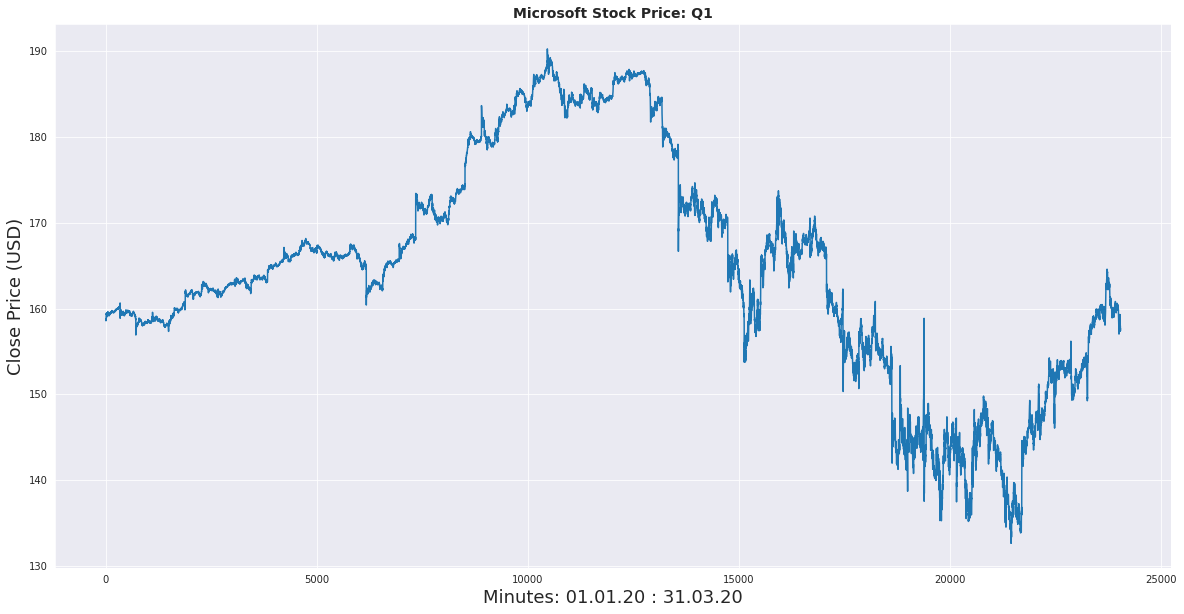

In [12]:
sns.set_style("darkgrid")
plt.figure(figsize = (20,10))
plt.plot(np.arange(len(df1)), df1[['Close']])
plt.title("Microsoft Stock Price: Q1",fontsize=14, fontweight='bold')
plt.xlabel('Minutes: 01.01.20 : 31.03.20',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

In [13]:
price_column_name = 'Close'
df_Close =  df1[[price_column_name]]
print(df_Close)

                                    Close
Local time                               
02.01.2020 14:30:00.000 GMT-0000  158.828
02.01.2020 14:31:00.000 GMT-0000  158.578
02.01.2020 14:32:00.000 GMT-0000  158.608
02.01.2020 14:33:00.000 GMT-0000  158.607
02.01.2020 14:34:00.000 GMT-0000  158.898
...                                   ...
31.03.2020 20:55:00.000 GMT+0100  157.998
31.03.2020 20:56:00.000 GMT+0100  157.847
31.03.2020 20:57:00.000 GMT+0100  157.527
31.03.2020 20:58:00.000 GMT+0100  157.418
31.03.2020 20:59:00.000 GMT+0100  157.718

[24038 rows x 1 columns]


#SUBSAMPLING - (To handle RAM limitations)
To mitigate RAM limitations, a the "SAMPLE" variable has been included to enable users to use an arbitrary slice of the dataset for the machine learning and training.

In [14]:
df_SAMPLE = pd.DataFrame(df_Close.head(int(len(df_Close)*SAMPLE)))

#This sample is used for the hidden layer analysis
print(df_SAMPLE)

                                    Close
Local time                               
02.01.2020 14:30:00.000 GMT-0000  158.828
02.01.2020 14:31:00.000 GMT-0000  158.578
02.01.2020 14:32:00.000 GMT-0000  158.608
02.01.2020 14:33:00.000 GMT-0000  158.607
02.01.2020 14:34:00.000 GMT-0000  158.898
...                                   ...
13.03.2020 17:20:00.000 GMT-0000  145.378
13.03.2020 17:21:00.000 GMT-0000  145.698
13.03.2020 17:22:00.000 GMT-0000  145.577
13.03.2020 17:23:00.000 GMT-0000  145.657
13.03.2020 17:24:00.000 GMT-0000  146.028

[19230 rows x 1 columns]


13.03.2020 17:24:00.000 GMT-0000


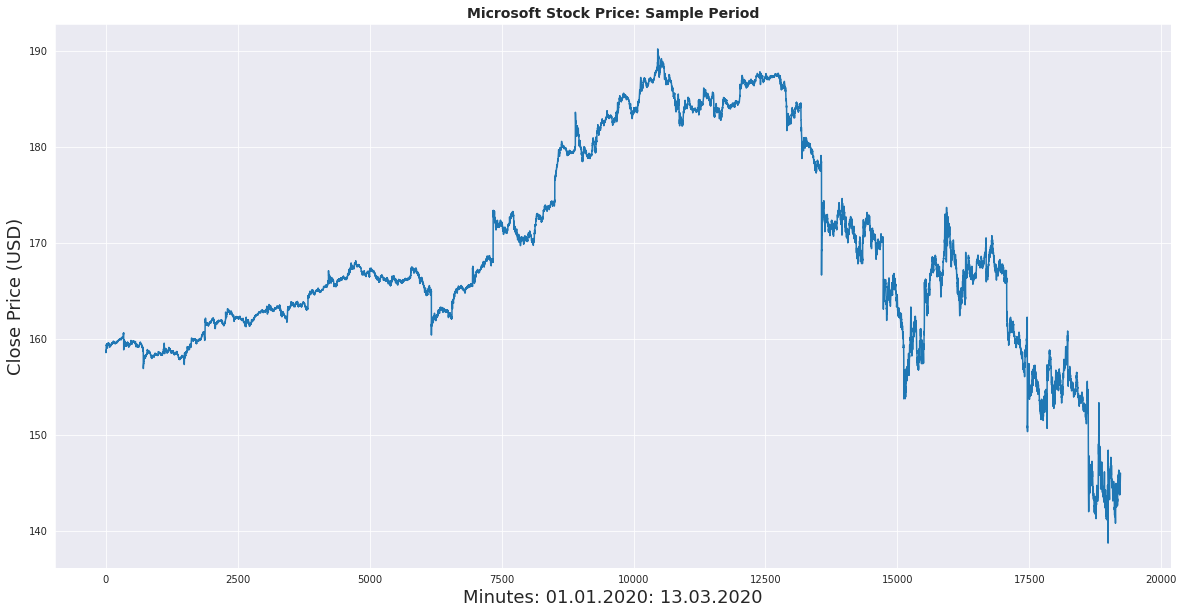

In [15]:
from datetime import datetime
sample_date = str((df1.index[len(df_SAMPLE)-1]))
sample_date = sample_date[0:10]
print(df1.index[len(df_SAMPLE)-1])
sns.set_style("darkgrid")
plt.figure(figsize = (20,10))
plt.plot(np.arange(len(df_SAMPLE)), df_SAMPLE[['Close']])
plt.title("Microsoft Stock Price: Sample Period",fontsize=14, fontweight='bold')
plt.xlabel('Minutes: 01.01.2020: '+ sample_date ,fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

In [16]:
df_SAMPLE_TRAIN = pd.DataFrame(df_SAMPLE.head(int(len(df_SAMPLE)*TRAIN_SPLIT)))
print(df_SAMPLE_TRAIN)
training_data = df_SAMPLE_TRAIN

                                    Close
Local time                               
02.01.2020 14:30:00.000 GMT-0000  158.828
02.01.2020 14:31:00.000 GMT-0000  158.578
02.01.2020 14:32:00.000 GMT-0000  158.608
02.01.2020 14:33:00.000 GMT-0000  158.607
02.01.2020 14:34:00.000 GMT-0000  158.898
...                                   ...
28.02.2020 18:46:00.000 GMT-0000  157.458
28.02.2020 18:47:00.000 GMT-0000  157.198
28.02.2020 18:48:00.000 GMT-0000  157.887
28.02.2020 18:49:00.000 GMT-0000  158.077
28.02.2020 18:50:00.000 GMT-0000  157.797

[15384 rows x 1 columns]


#DISTRIBUTION OF DATA AND RETURNS

Ups: 7489, Downs: 7268, No Change: 626, Total: 15383


Text(0.5, 1.0, 'Up/Down counts in 1-Min Period')

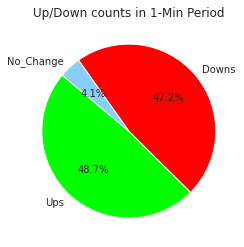

In [17]:
def up_down_return_checker(asset_prices):
  ups, downs, no_change = 0,0,0
  for i in range(0, len(asset_prices)-1):
    this_price = asset_prices[i]
    next_price = asset_prices[i+1]
    
    if next_price>this_price:
      ups+=1
    elif next_price<this_price:
      downs+=1
    else:
      no_change+=1

  return ups, downs, no_change

dummy = np.array(df_SAMPLE_TRAIN[['Close']])
u,d,nc = up_down_return_checker(dummy)
moves = 'Ups', 'Downs', 'No_Change'
sizes = [u,d,nc,]
colors = ['lime', 'red', 'lightskyblue']
plt.pie(sizes, explode=None, labels=moves, colors=colors,autopct='%1.1f%%', shadow=False, startangle=140)

print('Ups: {}, Downs: {}, No Change: {}, Total: {}'.format(u,d,nc,len(dummy)-1))
plt.title('Up/Down counts in 1-Min Period')

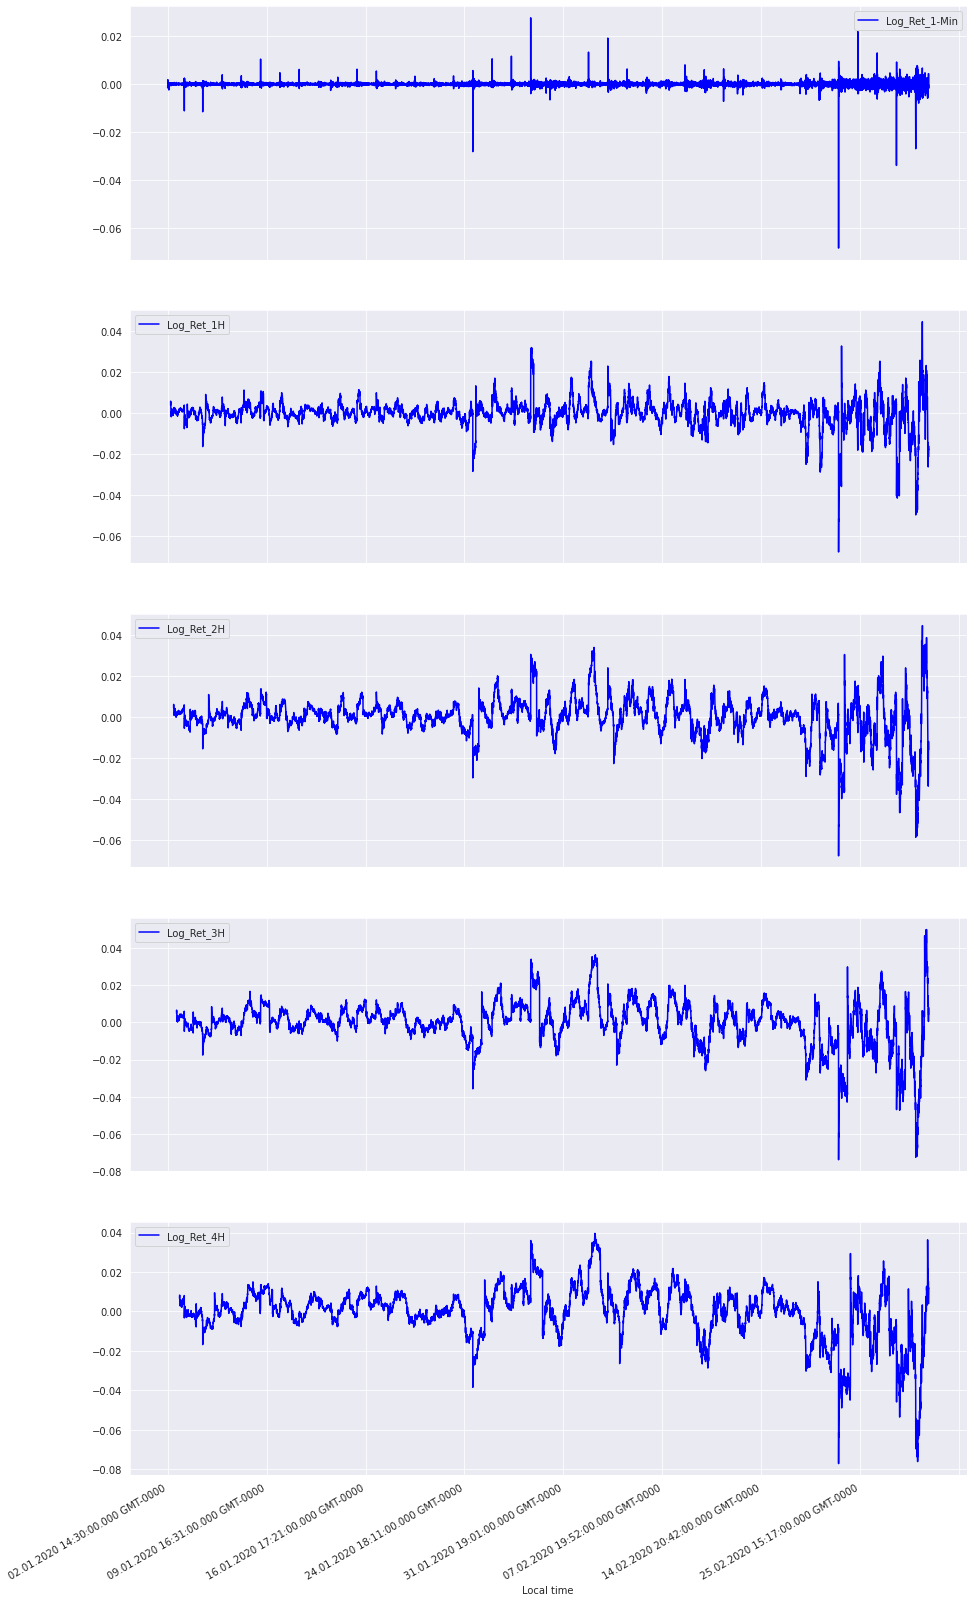

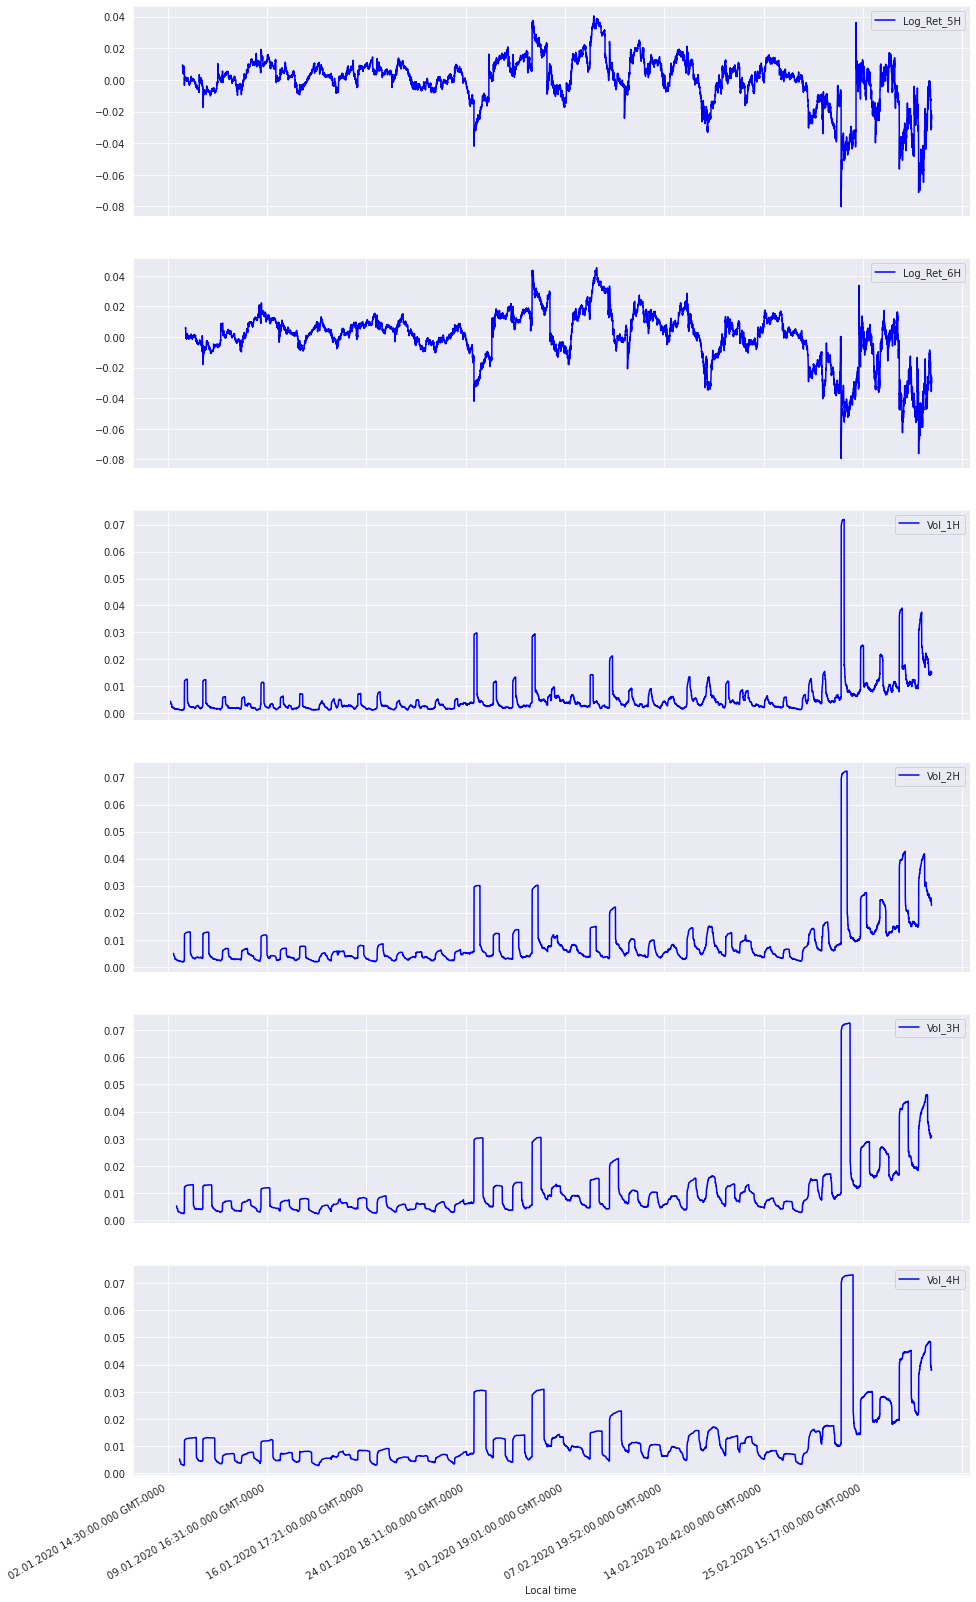

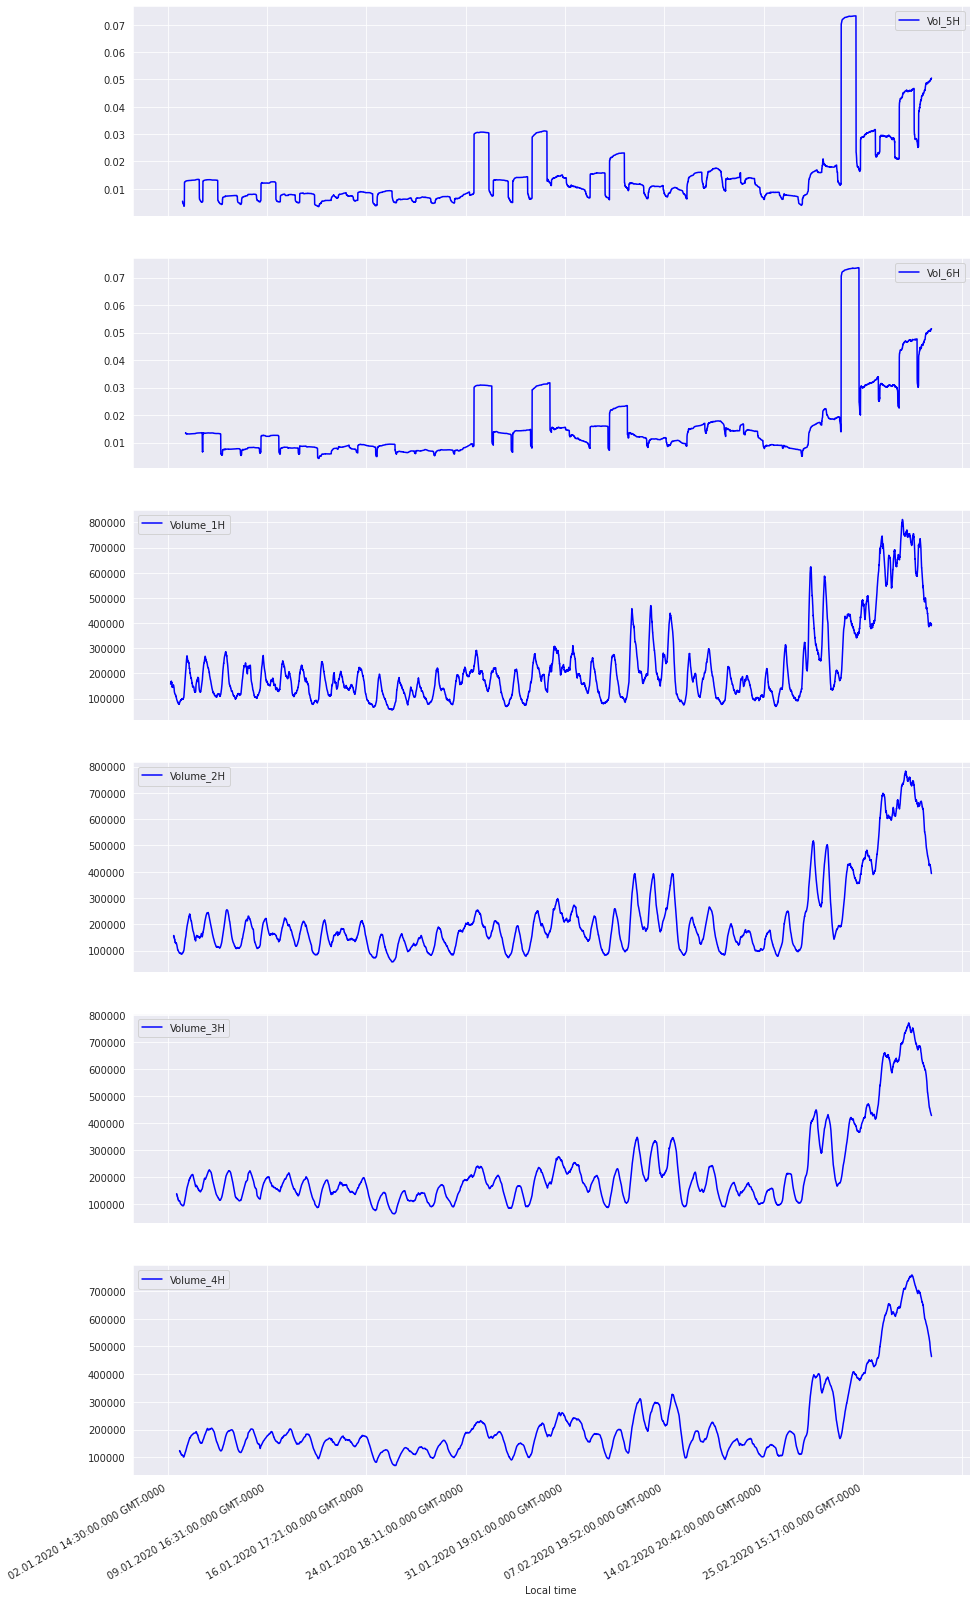

In [18]:
df_INTRA_DETAIL = df_SAMPLE_TRAIN

df_INTRA_DETAIL['Log_Ret_1-Min']=np.log(df_INTRA_DETAIL['Close'] / df_INTRA_DETAIL['Close'].shift(1))

df_INTRA_DETAIL['Log_Ret_1H']=pd.Series(df_INTRA_DETAIL['Log_Ret_1-Min']).rolling(window=60).sum()
df_INTRA_DETAIL['Log_Ret_2H']=pd.Series(df_INTRA_DETAIL['Log_Ret_1-Min']).rolling(window=60*2).sum()
df_INTRA_DETAIL['Log_Ret_3H']=pd.Series(df_INTRA_DETAIL['Log_Ret_1-Min']).rolling(window=60*3).sum()
df_INTRA_DETAIL['Log_Ret_4H']=pd.Series(df_INTRA_DETAIL['Log_Ret_1-Min']).rolling(window=60*4).sum()
df_INTRA_DETAIL['Log_Ret_5H']=pd.Series(df_INTRA_DETAIL['Log_Ret_1-Min']).rolling(window=60*5).sum()
df_INTRA_DETAIL['Log_Ret_6H']=pd.Series(df_INTRA_DETAIL['Log_Ret_1-Min']).rolling(window=60*6).sum()

df_INTRA_DETAIL.iloc[:,1:6].plot(subplots=True, color='blue', figsize=(15, 30), );

df_INTRA_DETAIL['Vol_1H']=pd.Series(df_INTRA_DETAIL['Log_Ret_1-Min']).rolling(window=60).std()*np.sqrt(60)
df_INTRA_DETAIL['Vol_2H']=pd.Series(df_INTRA_DETAIL['Log_Ret_1-Min']).rolling(window=60*2).std()*np.sqrt(60*2)
df_INTRA_DETAIL['Vol_3H']=pd.Series(df_INTRA_DETAIL['Log_Ret_1-Min']).rolling(window=60*3).std()*np.sqrt(60*3)
df_INTRA_DETAIL['Vol_4H']=pd.Series(df_INTRA_DETAIL['Log_Ret_1-Min']).rolling(window=60*4).std()*np.sqrt(60*4)
df_INTRA_DETAIL['Vol_5H']=pd.Series(df_INTRA_DETAIL['Log_Ret_1-Min']).rolling(window=60*5).std()*np.sqrt(60*5)
df_INTRA_DETAIL['Vol_6H']=pd.Series(df_INTRA_DETAIL['Log_Ret_1-Min']).rolling(window=60*6).std()*np.sqrt(60*6)

df_INTRA_DETAIL.iloc[:,6:12].plot(subplots=True, color='blue',figsize=(15, 30));

# Compute Volumes using the pandas rolling mean function
df_INTRA_DETAIL['Volume_1H']=pd.Series(df1['Volume']).rolling(window=60).mean()
df_INTRA_DETAIL['Volume_2H']=pd.Series(df1['Volume']).rolling(window=60*2).mean()
df_INTRA_DETAIL['Volume_3H']=pd.Series(df1['Volume']).rolling(window=60*3).mean()
df_INTRA_DETAIL['Volume_4H']=pd.Series(df1['Volume']).rolling(window=60*4).mean()
df_INTRA_DETAIL['Volume_5H']=pd.Series(df1['Volume']).rolling(window=60*5).mean()
df_INTRA_DETAIL['Volume_6H']=pd.Series(df1['Volume']).rolling(window=60*6).mean()

df_INTRA_DETAIL.iloc[:,12:18].plot(subplots=True, color='blue',figsize=(15, 30));


In [19]:
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)

Torch 1.4.0+cu92 CUDA 9.2


In [20]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the CPU


#DATA NORMALISATION
We ustilise the minmaxscaler which also provides additional functionality from the fit_transform method. 

This however is nothing more than:

In [21]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_data_normalised = sc.fit_transform(training_data)


#WINDOW MAKER|MAKING X,y INPUT AND OUTPUT LABELS
The creation of sequences within a time series for the purposes of ML are known as windows.
The methodology is to pick a sequence length (hyper-parameter), in this case Sequence Lenght=60 and use those as a means to predict the 61st element. 
Python arrays are indexed from 0. So the command: arr 1 = arr[0:60] and arr 2 = arr[60, 0] means the first array will take 60 values indexed from 0 to 59. Then the second array will take the 60th item. This will be the target value for the machine learning algorithm.
If we use the Time Series Data and produce a new window for each price: Window 1 = Data[0:60] (values indexed from 0 to 59), Label 1 = Data[60] and Window 2 = Data[60:120] (values indexed from 60 to 119) and Label 2 = Data[120], then based on the Windows, for those two instances, we expect the LSTM network to identify the weights to achieve the value at time point 60 and 120. After applying this method to the entire time series, we have created N - Sequence Length windows. Ie there are almost as many windows as records in the training data providing ample data for predictions. 

In [22]:
def window_maker(seq_l, time_series):
  X_t = []
  y_t = []
  for t in range(seq_l,len(time_series)):
    X_t.append(time_series[t-seq_l : t,0 ])
    y_t.append(time_series[t,0])
  return np.array(X_t), np.array(y_t)

In [23]:
X_i, y_i = window_maker(SEQUENCE_LENGTH,training_data_normalised )


In [24]:
#get the test data
testing_length = int(len(df_SAMPLE)*(1-TRAIN_SPLIT))
test_data = df_SAMPLE.tail(testing_length)[[price_column_name]].values
test_data_normalised = sc.fit_transform(test_data)

X_test = []
y_test = []

X_test, y_test = window_maker(SEQUENCE_LENGTH, test_data_normalised)
X_test = np.reshape(X_test, (X_test.shape[0],1,SEQUENCE_LENGTH))

print(X_test )
print(y_test )
X_test.shape[1]
len(X_test)
len(y_test)
print(np.shape(y_test))
print(np.shape(X_test))

###
df_blind = pd.DataFrame(df_Close.iloc[int(SAMPLE*len(df_Close))+1:int(SAMPLE*len(df_Close))+int(SAMPLE*len(df_Close))])
df_blind_norm = sc.fit_transform(df_blind)
X_blind = []
y_blind = []
X_blind, y_blind = window_maker(SEQUENCE_LENGTH, df_blind_norm)
X_blind = np.reshape(X_blind, (X_blind.shape[0],1,SEQUENCE_LENGTH))
X_blind.shape[1]

[[[0.53977517 0.53316742 0.53545582 ... 0.59295174 0.57924998 0.59009125]]

 [[0.53316742 0.53545582 0.52944878 ... 0.57924998 0.59009125 0.58840356]]

 [[0.53545582 0.52944878 0.53062159 ... 0.59009125 0.58840356 0.58951915]]

 ...

 [[0.15243571 0.14385423 0.14216654 ... 0.1813553  0.18993678 0.19909036]]

 [[0.14385423 0.14216654 0.14273864 ... 0.18993678 0.19909036 0.19562917]]

 [[0.14216654 0.14273864 0.13756114 ... 0.19909036 0.19562917 0.19791756]]]
[0.58840356 0.58951915 0.62069853 ... 0.19562917 0.19791756 0.20852999]
(3725,)
(3725, 1, 120)


1

##Dimensions of input data
Each element of X_i variable, the input, is a window and there are len(training_data) - sequence length number of windows all stored in X_i. 

In [25]:
X_i = np.reshape(X_i, (X_i.shape[0],1,SEQUENCE_LENGTH))
print(np.shape(X_i))



(15264, 1, 120)


#THE LSTM ARCHITECTURE
Conventional architecture, CNN, FCN etc do not remember previous information. This is because when we look at a perceptron (as in the Advanced ML classes) the perceptron had no linkage bewteen the middle layer back to itself. There was an input layer, middle layer and an output layer.

RNNs have a loop on itself within the neural network layer. 


![](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)


However, for cases like *non - farm payroll* announced on the economic calendar, monthly, the pricing patterns are remarbly similar - low volatility, slight dip before the announcement. The issue is when the RNN faces the same pattern again, the monthly gap can appear to be far, therefore recalling historical predictions can be difficult. Long term dependencies can be an issue for RNNs. 

This means there should be a stateful structure due to weekly, monthly and seasonality common in stocks, not just MSFT, but travel stocks for example. 

LSTMs resolve this issue.

![](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)



*(Reference: Colah|Github)*

In [26]:
#LSTM with hidden layers
#This was my own creation
class RNN_H(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size):
        super(RNN_H, self).__init__()

        self.rnn = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers,
            batch_first=True,
            #dropout=0.1, #we are implementing a single layer, therefore dropout not required. 
        )
        self.out = nn.Linear(h_size, o_size)
    
    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)  
        #r_out, hidden_state = self.rnn(x, h_state.detach())       
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.reshape(-1, hidden_size)
        outs = self.out(r_out)

        return outs, hidden_state


Ensure GPU to attain maximum RAM capacity.

#BATCH PROCESSING
##LIMITATIONS
To generalise the model, we utilise the train loader. 
This significantly slows down the performance, therefore if this software is used for the purposes of real time trading, then a customised trainloader will need to be developed (there are a few) however for this research exercise, utilising the trainloader was not an issue. 
##BATCH SIZE
Though this is not an exercise to determine batch size, we assume batch size of 256 is sufficient for the full dataset. 
##DROP LAST
An important step in train loading is the inability to always sub divide the data into equal batch sizes. Unequal batch sizes can cause problems between the expected output from the network and the actual output as the data is retrieved from the train loader. 
To circumvent this issue, as we are using small batch sizes, we drop the last item. This results in the loss of some data but as we are using 1-minute data, dropping the last batch is not a major issue


**EARLY STOPPAGE:** Training can be slow, erratic and behave unexpectedly, measures have been introduced to circumvent loss on generalisation and model accuracy by deploying a simple early break mechanism. 

To find the balance between the number of epochs and accuracy, we break the loop when a certain accuracy has been met and a number of epochs has been exceeded (so achieving the minimum threshold isn't fluke).

In [27]:
#input_data = Variable(torch.from_numpy(X_i).float()).cuda()
#labels = Variable(torch.from_numpy(y_i).float()).cuda()

input_data = Variable(torch.from_numpy(X_i).float()).cpu()
labels = Variable(torch.from_numpy(y_i).float()).cpu()

train_tensor = TensorDataset(input_data, labels) 
train_loader = DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = False, drop_last=True)

In [28]:
#test_data_torch = Variable(torch.from_numpy(X_test).float()).cuda()
#test_labels = Variable(torch.from_numpy(y_test).float()).cuda()

test_data_torch = Variable(torch.from_numpy(X_test).float()).cpu()
test_labels = Variable(torch.from_numpy(y_test).float()).cpu()

test_tensor = TensorDataset(test_data_torch, test_labels) 
test_loader = DataLoader(dataset = test_tensor, batch_size = batch_size, shuffle = False, drop_last=True)


#test_data_torch_blind = Variable(torch.from_numpy(X_blind).float()).cuda()
#test_labels_blind = Variable(torch.from_numpy(y_blind).float()).cuda()

test_data_torch_blind = Variable(torch.from_numpy(X_blind).float()).cpu()
test_labels_blind = Variable(torch.from_numpy(y_blind).float()).cpu()

#TRAINING and VALIDATION LSTM - FOR VARYING HIDDEN LAYER
To allow the network to recall information from previous sequences, we first examine the use of hidden layers. 




In [29]:
def rnn_h_maker(h_l):
  rnn_h = RNN_H(SEQUENCE_LENGTH, h_l, NUM_LAYERS, OUTPUT_SIZE )
  #rnn_h.cuda()
  rnn_h.cpu()
  optimiser_h = torch.optim.Adam(rnn_h.parameters(), lr=learning_rate)
  return rnn_h, optimiser_h

In the following routine, we maintain a fixed number of epochs, 50 and experiment with tau = 0.0001 and 0.00001 for the varying hidden layers. 
We find tau = 0.00001 is best. Tau can be amended in the Learning Rate variable in the above sections as required.

In [30]:
#train and validation - for fixed 50 epochs
def train_doer0(h_l, num_epochs = num_epochs):
  criterion = nn.MSELoss()
  hidden_state = None #Initialise hidden state.

  rnn_lstm, optimiser = rnn_h_maker(h_l)
  loss_on_epoch = np.zeros((2,num_epochs, len(train_loader)))
  epoch_loss = 0
  epoch_loss_last = 0
  epoch_delta =0
  epoch_avd=[] # stores the average for that epoch across all batches
  epoch_avd_val = [] # stores the average for that epoch across all batches
 
  predictions = []
  targets = []
  duration = [] 
  
  print("Hidden Layers: " + str(h_l))

  for epoch in range(min_epochs):
      rnn_lstm.train()
      for i, (input_data, labels) in enumerate(train_loader):
          start = time.time()
          output,hidden_state = rnn_lstm(input_data,hidden_state)
          loss = criterion((output.view(-1)), labels)
          loss_on_epoch[0,epoch,i] = loss.item()
          #backprop and perform adam optimisation
          optimiser.zero_grad()
          loss.backward(retain_graph=True)                     # back propagation
          optimiser.step() 
      epoch_arr = loss_on_epoch[0,epoch, :]
      epoch_loss_last = np.mean(loss_on_epoch[0,epoch-1, :])
      epoch_loss = np.mean(epoch_arr)
      epoch_delta = epoch_loss - epoch_loss_last
      epoch_avd.append(epoch_loss)
      duration.append(time.time()-start)
      


      rnn_lstm.eval()
      for j, (input_data, labels) in enumerate(test_loader):
        with torch.no_grad():
          output_val,hidden_state = rnn_lstm(input_data, hidden_state)
          #output_val = rnn_lstm(input_data)
          loss = criterion((output_val.view(-1)), labels)
          loss_on_epoch[1,epoch, j] = loss.item()
          predictions.append(output_val)
          targets.append(labels)
      epoch_loss_test = np.mean(loss_on_epoch[1,epoch, :])

      epoch_avd_val.append(epoch_loss_test)
      print('epoch {} | training loss {} | validation loss {} | train/validation {} | time: {}'.format(epoch, epoch_loss,epoch_loss_test, epoch_loss/epoch_loss_test,duration[epoch]))
            
      if epoch >= min_epochs-1:
        num_epochs = epoch
        print("MSE:" + str(epoch_loss_test))
        break;
  return epoch_avd, epoch_avd_val, duration,predictions, targets, rnn_lstm

In [31]:
training_loss_10, validation_loss_10, duration_10, p10, t10, rnn_10= train_doer0(int(SEQUENCE_LENGTH*0.1))
training_loss_20, validation_loss_20, duration_20, p20, t20, rnn_20= train_doer0(int(SEQUENCE_LENGTH*0.2))
training_loss_40, validation_loss_40, duration_40, p40, t40, rnn_40=  train_doer0(int(SEQUENCE_LENGTH*((2/3))+1))
training_loss_80, validation_loss_80, duration_80, p80, t80, rnn_80=  train_doer0(int(SEQUENCE_LENGTH*(1)))
training_loss_160, validation_loss_160, duration_160, p160, t160, rnn_160 = train_doer0(int(SEQUENCE_LENGTH*1.5))

Hidden Layers: 12
epoch 0 | training loss 0.1232303229932105 | validation loss 0.038620025211534764 | train/validation 3.190840045241734 | time: 0.062256574630737305
epoch 1 | training loss 0.11281407745436654 | validation loss 0.03552254545896993 | train/validation 3.175844410831191 | time: 0.060628414154052734
epoch 2 | training loss 0.10369384989672206 | validation loss 0.032785225233410376 | train/validation 3.1628225567610553 | time: 0.06056857109069824
epoch 3 | training loss 0.09557421580344237 | validation loss 0.03031994389780497 | train/validation 3.1521897311413403 | time: 0.061782121658325195
epoch 4 | training loss 0.0882787075054894 | validation loss 0.028083789493825475 | train/validation 3.1434044014928406 | time: 0.0695333480834961
epoch 5 | training loss 0.0816941351123683 | validation loss 0.02604816236801572 | train/validation 3.136272492399683 | time: 0.061539649963378906
epoch 6 | training loss 0.07573525020132489 | validation loss 0.024191964275629845 | train/val

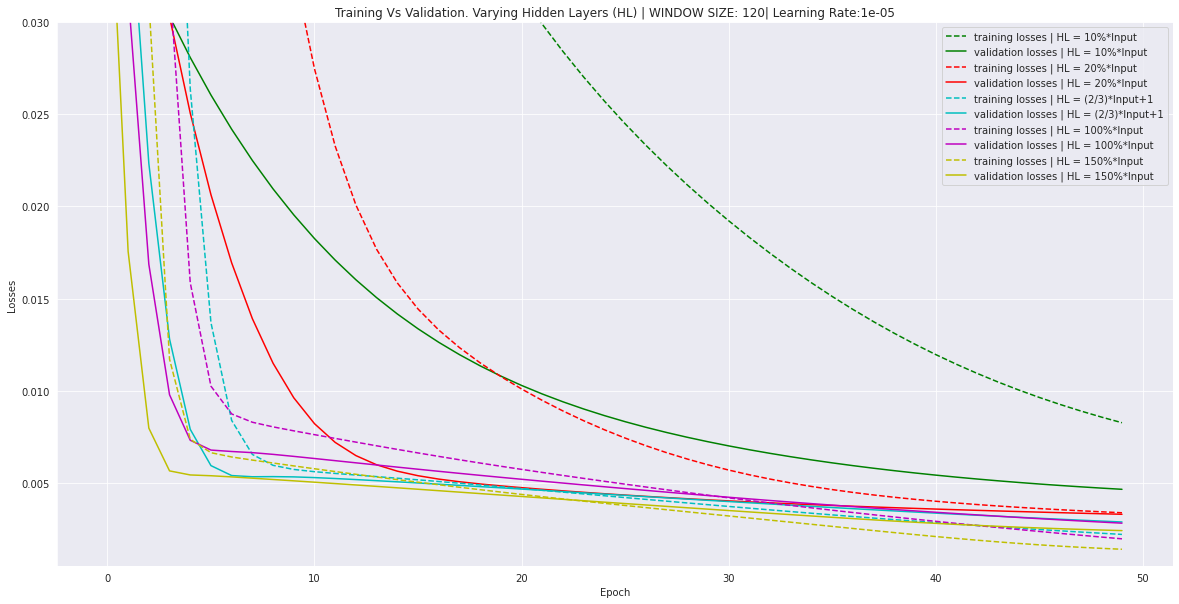

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20,10))
plt.title("Training Vs Validation. Varying Hidden Layers (HL) | WINDOW SIZE: " + str(SEQUENCE_LENGTH) + "| Learning Rate:" + str(learning_rate))
plt.plot(training_loss_10, label='training losses | HL = 10%*Input',color ='g', linestyle = '--')
plt.plot(validation_loss_10, label = 'validation losses | HL = 10%*Input',color ='g')
plt.plot(training_loss_20, label='training losses | HL = 20%*Input',linestyle ='--',color ='r')
plt.plot(validation_loss_20, label = 'validation losses | HL = 20%*Input',color ='r')
plt.plot(training_loss_40, label='training losses | HL = (2/3)*Input+1',linestyle ='--',color ='c')
plt.plot(validation_loss_40, label = 'validation losses | HL = (2/3)*Input+1',color ='c')
plt.plot(training_loss_80, label='training losses | HL = 100%*Input',linestyle ='--',color ='m')
plt.plot(validation_loss_80, label = 'validation losses | HL = 100%*Input',color ='m')
plt.plot(training_loss_160, label='training losses | HL = 150%*Input',linestyle ='--',color ='y')
plt.plot(validation_loss_160, label = 'validation losses | HL = 150%*Input',color ='y')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.ylim(0.0005,0.03)
plt.legend()

In [36]:
#train and validation
def train_doer(h_l, num_epochs = num_epochs):
  criterion = nn.MSELoss()
  hidden_state = None #Initialise hidden state.

  rnn_lstm, optimiser = rnn_h_maker(h_l)
  loss_on_epoch = np.zeros((2,num_epochs, len(train_loader)))
  epoch_loss = 0
  epoch_loss_last = 0
  epoch_delta =0
  epoch_avd=[] # stores the average for that epoch across all batches
  epoch_avd_val = [] # stores the average for that epoch across all batches
 
  predictions = []
  targets = []
  duration = [] 
  
  print("Hidden Layers: " + str(h_l))

  for epoch in range(num_epochs):
      rnn_lstm.train()
      for i, (input_data, labels) in enumerate(train_loader):
          start = time.time()
          output,hidden_state = rnn_lstm(input_data,hidden_state)
          loss = criterion((output.view(-1)), labels)
          loss_on_epoch[0,epoch,i] = loss.item()
          #backprop and perform adam optimisation
          optimiser.zero_grad()
          loss.backward(retain_graph=True)                     # back propagation
          optimiser.step() 
      epoch_arr = loss_on_epoch[0,epoch, :]
      epoch_loss_last = np.mean(loss_on_epoch[0,epoch-1, :])
      epoch_loss = np.mean(epoch_arr)
      epoch_delta = epoch_loss - epoch_loss_last
      epoch_avd.append(epoch_loss)
      duration.append(time.time()-start)
      
      rnn_lstm.eval()
      for j, (input_data, labels) in enumerate(test_loader):
        with torch.no_grad():
          output_val,hidden_state = rnn_lstm(input_data, hidden_state)
          #output_val = rnn_lstm(input_data)
          loss = criterion((output_val.view(-1)), labels)
          loss_on_epoch[1,epoch, j] = loss.item()
          predictions.append(output_val)
          targets.append(labels)
      epoch_loss_test = np.mean(loss_on_epoch[1,epoch, :])


      #if we are flat
      if abs(epoch_delta) < epoch_delta_limit:
        #if loss is lower than threshold
        if epoch_loss_test < max_mse:
          #we have been flat for how long?
          flat_count = flat_count+1
          print(str(flat_count) + " Flattening")
      
      if epoch_loss_test > max_mse:
          flat_count = 0


      epoch_avd_val.append(epoch_loss_test)
      print('epoch {} | training loss {} | validation loss {} | train/validation {} | time: {}'.format(epoch, epoch_loss,epoch_loss_test, epoch_loss/epoch_loss_test,duration[epoch]))
           

      #break if it's over-fitting
      if epoch_loss_test>=epoch_loss:
        num_epochs = epoch
        print("MSE:" + str(epoch_loss_test) + "stopped to prevent over-fitting")
        break;

      #if epoch >= min_epochs-1:
      if (flat_count >= flat_loss_count or epoch_loss_test < max_mse): #stop when the curve is flat or error is less than 0.002. Which hidden layer configuration meets this criteria first?

        num_epochs = epoch
        print("MSE:" + str(epoch_loss_test))
        
        if flat_count >= flat_loss_count:
          print("validation loss curve has flattened with gradient < " + str(epoch_delta_limit) + "over " + str(flat_loss_count) +"consecutive epochs"  )
          print("MSE < " + str(max_mse))
        
        break;

  return epoch_avd, epoch_avd_val, duration,predictions, targets, rnn_lstm

In [37]:
training_loss_10, validation_loss_10, duration_10, p10, t10, rnn_10= train_doer(int(SEQUENCE_LENGTH*0.1))
training_loss_20, validation_loss_20, duration_20, p20, t20, rnn_20= train_doer(int(SEQUENCE_LENGTH*0.2))
training_loss_40, validation_loss_40, duration_40, p40, t40, rnn_40=  train_doer(int(SEQUENCE_LENGTH*((2/3))+1))
training_loss_80, validation_loss_80, duration_80, p80, t80, rnn_80=  train_doer(int(SEQUENCE_LENGTH*(1)))
training_loss_160, validation_loss_160, duration_160, p160, t160, rnn_160 = train_doer(int(SEQUENCE_LENGTH*1.5))

Hidden Layers: 12
epoch 0 | training loss 0.21506762220445325 | validation loss 0.06661801930453817 | train/validation 3.22837010841303 | time: 0.06694817543029785
epoch 1 | training loss 0.18327916789231663 | validation loss 0.057874216398192666 | train/validation 3.166853554116375 | time: 0.06602263450622559
epoch 2 | training loss 0.15842288820925404 | validation loss 0.050418339985407006 | train/validation 3.142167874926221 | time: 0.06138968467712402
epoch 3 | training loss 0.13694136193558826 | validation loss 0.043855479208089534 | train/validation 3.122559926567356 | time: 0.0635213851928711
epoch 4 | training loss 0.1182001644619188 | validation loss 0.03802959118985524 | train/validation 3.108110309990654 | time: 0.06171369552612305
epoch 5 | training loss 0.10181937461434784 | validation loss 0.032856081880755346 | train/validation 3.098950598670929 | time: 0.06164097785949707
epoch 6 | training loss 0.08747910034164029 | validation loss 0.02827505130415498 | train/validatio

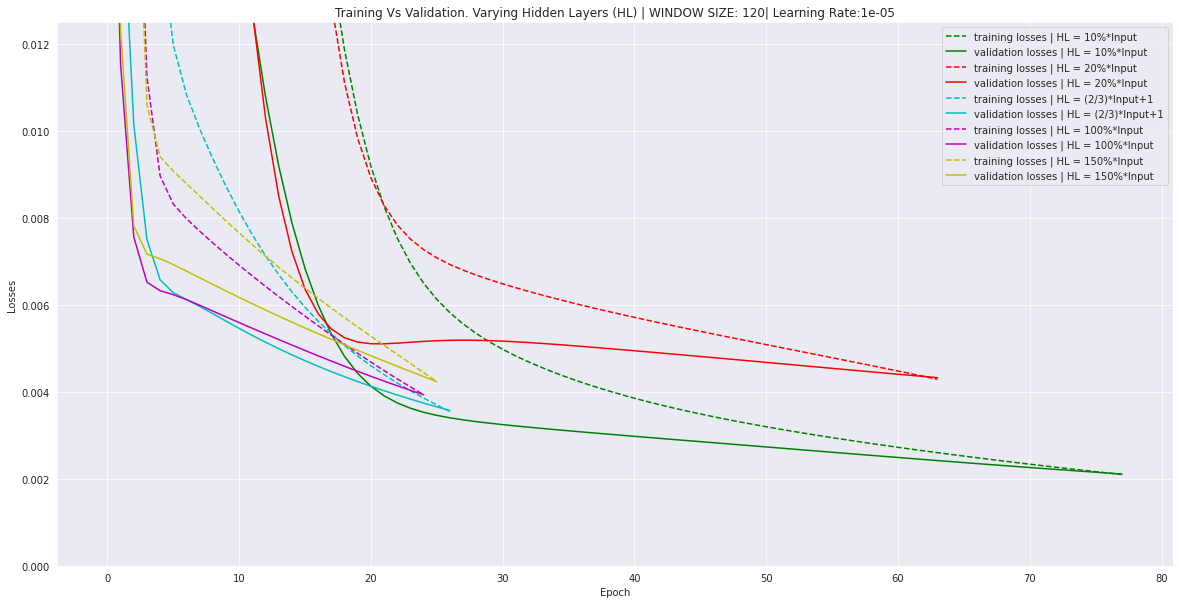

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20,10))
plt.title("Training Vs Validation. Varying Hidden Layers (HL) | WINDOW SIZE: " + str(SEQUENCE_LENGTH) + "| Learning Rate:" + str(learning_rate))
plt.plot(training_loss_10, label='training losses | HL = 10%*Input',color ='g', linestyle = '--')
plt.plot(validation_loss_10, label = 'validation losses | HL = 10%*Input',color ='g')
plt.plot(training_loss_20, label='training losses | HL = 20%*Input',linestyle ='--',color ='r')
plt.plot(validation_loss_20, label = 'validation losses | HL = 20%*Input',color ='r')
plt.plot(training_loss_40, label='training losses | HL = (2/3)*Input+1',linestyle ='--',color ='c')
plt.plot(validation_loss_40, label = 'validation losses | HL = (2/3)*Input+1',color ='c')
plt.plot(training_loss_80, label='training losses | HL = 100%*Input',linestyle ='--',color ='m')
plt.plot(validation_loss_80, label = 'validation losses | HL = 100%*Input',color ='m')
plt.plot(training_loss_160, label='training losses | HL = 150%*Input',linestyle ='--',color ='y')
plt.plot(validation_loss_160, label = 'validation losses | HL = 150%*Input',color ='y')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.ylim(0.0,0.0125)
plt.legend()


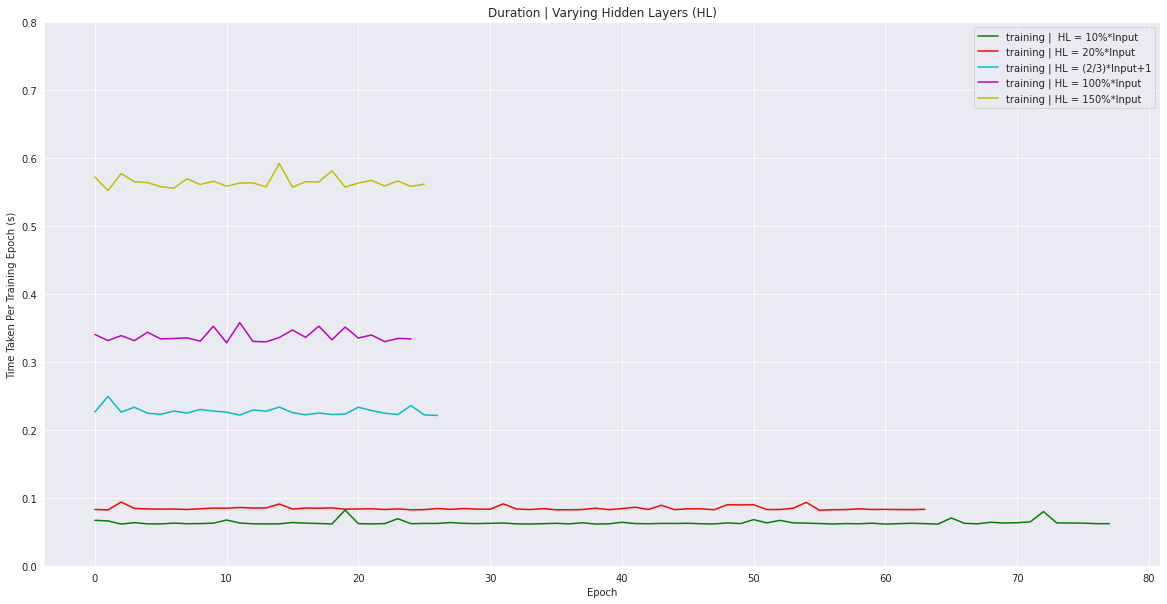

In [39]:
plt.figure(figsize = (20,10))
plt.title("Duration | Varying Hidden Layers (HL)")
plt.plot(duration_10, label = 'training |  HL = 10%*Input', color='g')
plt.plot(duration_20, label='training | HL = 20%*Input', color='r')
plt.plot(duration_40, label = 'training | HL = (2/3)*Input+1', color='c')
plt.plot(duration_80, label='training | HL = 100%*Input', color='m')
plt.plot(duration_160, label = 'training | HL = 150%*Input', color='y')
plt.ylim(0.0, 0.8)

plt.xlabel('Epoch')
plt.ylabel('Time Taken Per Training Epoch (s)')
plt.legend()

Text(0.5, 1.0, 'Time Taken (mins) | Varying Hidden Layers')

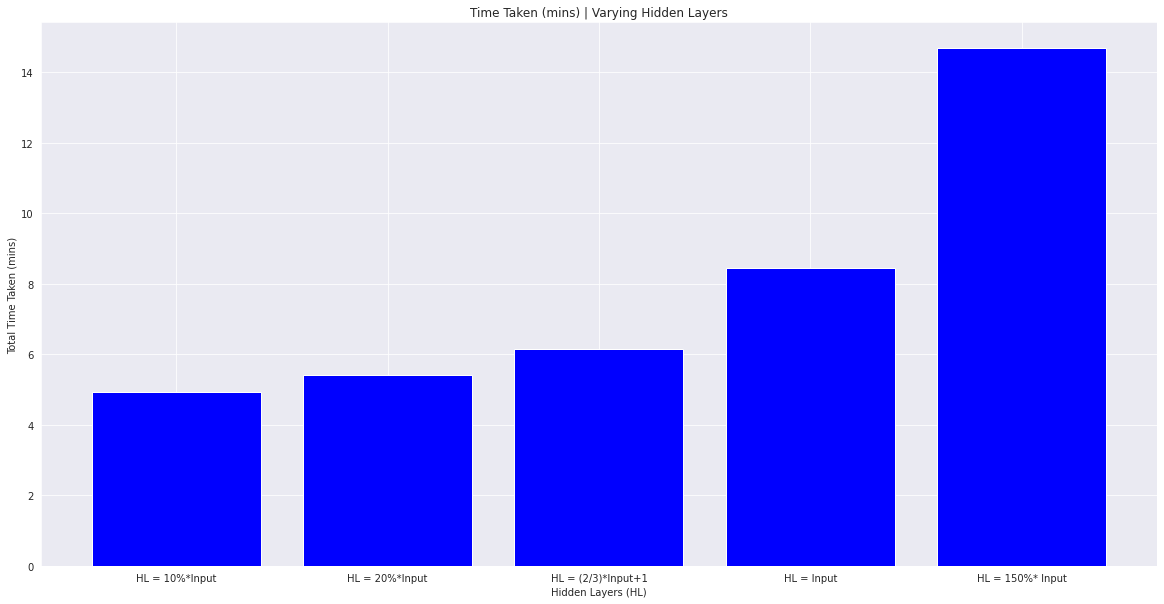

In [40]:
#Source:'https://benalexkeen.com/bar-charts-in-matplotlib/' # Plotting bar charts
from matplotlib import style
#style.use('ggplot')
plt.figure(figsize = (20,10))
#ax1 = fig.add_subplot(111, projection='3d')
x = ['HL = 10%*Input', 'HL = 20%*Input', 'HL = (2/3)*Input+1', 'HL = Input', 'HL = 150%* Input']
y = [np.sum(duration_10), np.sum(duration_20), np.sum(duration_40), np.sum(duration_80), np.sum(duration_160)]
x_pos = [i for i, _ in enumerate(x)]

plt.xticks(x_pos, x)
plt.bar(x_pos, y, color='blue')
plt.xlabel("Hidden Layers (HL)")
plt.ylabel("Total Time Taken (mins)")
plt.title("Time Taken (mins) | Varying Hidden Layers")

In [ ]:
#train and validation
def train_doer1(h_l, num_epochs = num_epochs):
  criterion = nn.MSELoss()
  hidden_state = None #Initialise hidden state.

  rnn_lstm, optimiser = rnn_h_maker(h_l)
  loss_on_epoch = np.zeros((2,num_epochs, len(train_loader)))
  epoch_loss = 0
  epoch_loss_last = 0
  epoch_delta =0
  epoch_avd=[] # stores the average for that epoch across all batches
  epoch_avd_val = [] # stores the average for that epoch across all batches
  av_epoch_delta = 0
  predictions = []
  targets = []
  duration = [] 
  flat_count =0;

  print("Hidden Layers: " + str(h_l))

  for epoch in range(num_epochs):
      rnn_lstm.train()
      for i, (input_data, labels) in enumerate(train_loader):
          start = time.time()
          output,hidden_state = rnn_lstm(input_data,hidden_state)
          loss = criterion((output.view(-1)), labels)
          loss_on_epoch[0,epoch,i] = loss.item()
          #backprop and perform adam optimisation
          optimiser.zero_grad()
          loss.backward(retain_graph=True)                     # back propagation
          optimiser.step() 
      epoch_arr = loss_on_epoch[0,epoch, :]
      epoch_loss_last = np.mean(loss_on_epoch[0,epoch-1, :])
      epoch_loss = np.mean(epoch_arr)
      epoch_delta = epoch_loss - epoch_loss_last



      epoch_avd.append(epoch_loss)
      duration.append(time.time()-start)

      rnn_lstm.eval()
      for j, (input_data, labels) in enumerate(test_loader):
        with torch.no_grad():
          output_val,hidden_state = rnn_lstm(input_data, hidden_state)
          #output_val = rnn_lstm(input_data)
          loss = criterion((output_val.view(-1)), labels)
          loss_on_epoch[1,epoch, j] = loss.item()
          predictions.append(output_val)
          targets.append(labels)
      epoch_loss_test = np.mean(loss_on_epoch[1,epoch, :])
      
      #if we are flat
      if abs(epoch_delta) < epoch_delta_limit:
        #if loss is lower than threshold
        if epoch_loss_test < max_mse:
          #we have been flat for how long?
          flat_count = flat_count+1
          print(str(flat_count) + " Flattening")
      
      if epoch_loss_test > max_mse:
          flat_count = 0

      epoch_avd_val.append(epoch_loss_test)
      print('epoch {} | training loss {} | validation loss {} | train/validation {} | time: {}'.format(epoch, epoch_loss,epoch_loss_test, epoch_loss/epoch_loss_test,duration[epoch]))
      if epoch >= min_epochs-1:
        if flat_count >= flat_loss_count and epoch_loss_test>=epoch_loss: #stop when the curve is flat and when over-fitting is happening to stop over-fitting the data
          num_epochs = epoch
          print("WE HAVE STABILISED TO " +str(epoch_delta_limit)+ "SLOPE, MSE:" + str(epoch_loss_test))
          print("ACCURACY, MSE:" + str(epoch_loss))
          break;
  return epoch_avd, epoch_avd_val, duration,predictions, targets, rnn_lstm

In [ ]:
#As read by Jeff horton's book on ML with Java, we select this length of hidden layers. 
training_loss_40, validation_loss_40, duration_40, p40, t40, rnn_40=  train_doer1(int(SEQUENCE_LENGTH*((2/3))+1))
training_loss_40, validation_loss_40, duration_40, p40, t40, rnn_40=  train_doer1(int(SEQUENCE_LENGTH*(0.1)))

In [ ]:
plt.figure(figsize = (20,10))
plt.title("Training Vs Validation. 81 Hidden Layers | WINDOW SIZE: " + str(SEQUENCE_LENGTH) + "| Learning Rate:" + str(learning_rate))
plt.plot(training_loss_40, label='training losses | HL = (2/3)*Input+1',linestyle ='--',color ='c')
plt.plot(validation_loss_40, label = 'validation losses | HL = (2/3)*Input+1',color ='c')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.ylim(0.0005,0.03)
plt.legend()

In [59]:
#PREDICTIONS, TRAINING:
hidden_state = None
train_actuals = np.asarray(training_data["Close"])
rnn_40.eval()
#yhat, h = rnn_40(input_data, hidden_state)
yhat, h = rnn_40(input_data, hidden_state)
#pred_series = (sc.inverse_transform(yhat.detach().cuda().numpy() ))
pred_series = (sc.inverse_transform(yhat.detach().cpu().numpy() ))
pred_series = np.asarray(pred_series).reshape(-1,1)
print(pred_series)

[[136.19359]
 [136.18887]
 [136.1797 ]
 ...
 [136.62082]
 [136.58539]
 [136.57788]]


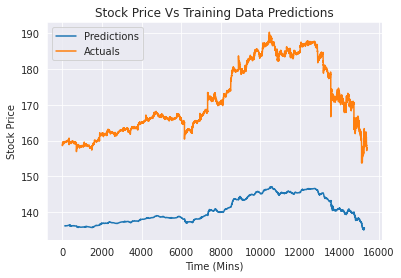

In [60]:
pred_series_df= pd.DataFrame(pred_series)
plt.plot(np.asarray(pred_series_df.shift(SEQUENCE_LENGTH)), label = "Predictions")
plt.plot(np.asarray(train_actuals), label = "Actuals")
plt.xlabel("Time (Mins)")
plt.ylabel("Stock Price")
plt.title("Stock Price Vs Training Data Predictions")
plt.legend()


In [61]:
def RMSE_Machtest(arr1, arr2):
  rmse1 = np.square(np.subtract(arr1, arr2)).mean()
  return(rmse1**0.5)

print("RMSE: "+str(RMSE_Machtest(train_actuals,pred_series )))

RMSE: 32.45085853628498


In [62]:
#PREDICTIONS, TEST (VALIDATION):
hidden_state = None
rnn_40.eval()
yhat_test, h = rnn_40(test_data_torch, hidden_state)
pred_series_test = (sc.inverse_transform(yhat_test.detach().cpu().numpy() ))
#pred_series_test = (sc.inverse_transform(yhat_test.detach().gpu().numpy() ))
pred_series_test = np.asarray(pred_series_test).reshape(-1,1)

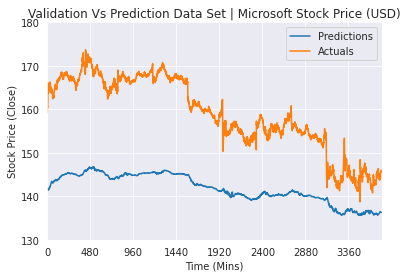

In [63]:
pred_series_test_df= pd.DataFrame(pred_series_test)

plt.plot(np.asarray(pred_series_test_df), label = "Predictions")
test_data = pd.DataFrame(test_data)
plt.title("Validation Vs Prediction Data Set | Microsoft Stock Price (USD)")
plt.plot(np.asarray(test_data.shift(-SEQUENCE_LENGTH)), label = "Actuals")
plt.ylim(130,180)
plt.xlabel("Time (Mins)")
plt.ylabel("Stock Price (Close)")
plt.xlim(0, len(pred_series_test_df)+10)
plt.xticks(np.arange(0,len(pred_series_test_df)+10,480));
plt.legend()

In [64]:
print("RMSE: "+str(RMSE_Machtest(np.asarray(pred_series_test_df),np.asarray(test_data[-len(pred_series_test_df):]) )))

RMSE: 17.927478275114037


In [73]:
#TOTALLY BLIND DATASET
#Define totally blind dataset
hidden_state = None
#df_blind_torch = Variable(torch.from_numpy(X_blind).float()).cuda()
df_blind_torch = Variable(torch.from_numpy(X_blind).float()).cpu()
print(np.shape(df_blind_torch))
rnn_40.eval()
yhat_forward, h = rnn_10(df_blind_torch, hidden_state)
pred_series_blind = (sc.inverse_transform(yhat_forward.detach().cpu().numpy() ))
pred_series_blind = np.asarray(pred_series_blind).reshape(-1,1)
print(len(pred_series_blind))


torch.Size([4687, 1, 120])
4687


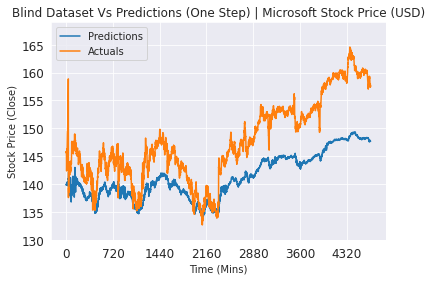

In [74]:
pred_series_blind_df = pd.DataFrame(pred_series_blind)

plt.plot(np.asarray(pred_series_blind_df), label = "Predictions")
plt.title("Blind Dataset Vs Predictions (One Step) | Microsoft Stock Price (USD)")
plt.plot(np.asarray(df_blind.shift(-SEQUENCE_LENGTH)), label = "Actuals")
plt.ylim(130,169)
plt.xlabel("Time (Mins)")
plt.xticks(np.arange(0,len(pred_series_blind_df)+1,720))
plt.tick_params(labelsize=12)
plt.ylabel("Stock Price (Close)")
plt.legend()


In [75]:
print("RMSE: "+str(RMSE_Machtest(np.asarray(pred_series_blind_df),np.asarray(df_blind[-len(pred_series_blind_df):]) )))

RMSE: 7.1888317916756135


In [77]:
#FORWARD PREDICTIONS - USING 1 WINDOW (SEQUENCE LENGTH, TO PREDICT ONE WINDOW FORWARD)
hidden_state = None
minutes_forward = SEQUENCE_LENGTH
rnn_10.eval()
#these is the period we use to forecast forward from.
forecast_inputs = df_blind[0:SEQUENCE_LENGTH]
forecast_actuals = df_blind[0:SEQUENCE_LENGTH*2]

#normalise the inputs:
forecast_inputs_T = sc.transform(forecast_inputs)

#reshape the inputs:
forecast_inputs_T= np.reshape(forecast_inputs_T, (1,1,SEQUENCE_LENGTH))

#turn the inputs into a tensor:
forecast_inputs_tensor = Variable(torch.from_numpy(forecast_inputs_T).float()).cpu()
#forecast_inputs_tensor = Variable(torch.from_numpy(forecast_inputs_T).float()).cuda()

In [81]:
fc = []
temp = []
fc_unorm = []
for i in range(minutes_forward):
  yhat_forward, h = rnn_10(forecast_inputs_tensor, hidden_state)
  temp = np.asarray(forecast_inputs_tensor.detach().cpu().numpy())
  temp = np.append(temp,yhat_forward[0].detach().cpu().numpy())
  fc = np.append(fc,yhat_forward[0].detach().cpu().numpy())
  temp = temp[1:SEQUENCE_LENGTH+1]
  temp = np.reshape(temp, (1,1,SEQUENCE_LENGTH))
  temp[0,0,SEQUENCE_LENGTH-1] = yhat_forward[0]
  temp_tensor = Variable(torch.from_numpy(temp).float()).cpu()
  forecast_inputs_tensor = temp_tensor

In [82]:
fc_inv_T = sc.inverse_transform(fc.reshape(-1,1))

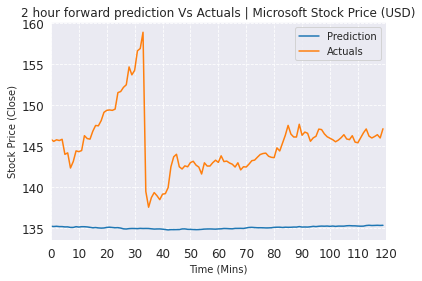

In [83]:

plt.plot(fc_inv_T, label = "Prediction")
forecast_actuals_df= pd.DataFrame(forecast_actuals)
plt.plot(np.asarray(forecast_actuals_df.shift(-SEQUENCE_LENGTH)), label = "Actuals")
plt.grid(True, linestyle='--')
plt.tick_params(labelsize=12)
plt.xticks(np.arange(0,SEQUENCE_LENGTH+1,10))
plt.xlabel("Time (Mins)")
plt.ylabel("Stock Price (Close)")
plt.title("2 hour forward prediction Vs Actuals | Microsoft Stock Price (USD)")
plt.xlim(0,120)
plt.legend()

In [84]:
print("RMSE: "+str(RMSE_Machtest(fc_inv_T,np.asarray(forecast_actuals_df[-SEQUENCE_LENGTH:]))))

RMSE: 10.855619381430627


In [ ]:
print(test_loader.dataset)
print(len(test_tensor))

In [ ]:
#UNIVERSAL ADVERSARIAL ATTACK

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True, drop_last=True)

In [ ]:
perturbation = Variable(torch.zeros(1,SEQUENCE_LENGTH), requires_grad = True).cpu()

In [ ]:
criterion = nn.MSELoss()
epsilon = 4
stepsize = 0.01
hidden_state = None
ad_N_epochs = 30
#assign the pre-trained model: 
rnn_lstm = rnn_40
rnn_lstm.eval()

import torch.nn.functional as F 

pert = []
itr = []

for epoch in range(ad_N_epochs):

    for i, (input_data, labels) in enumerate(train_loader):

        output, hidden_state = rnn_lstm(input_data + perturbation.repeat(batch_size, 1, 1),hidden_state)##
        
        loss = criterion((output.view(-1)), labels)
        rnn_lstm.zero_grad()##
        
        loss.backward(retain_graph=True)##
        #loss.backward()##

        perturbation.data = perturbation.data + perturbation.grad*stepsize
        perturbation.data = perturbation.data/torch.norm(perturbation.data.view(-1))*epsilon
        pert.append((input_data.data + perturbation.data))
    #if epoch %1 ==0:
    print('Iteration [%d/%d], Loss: %.4f'%(epoch+1, ad_N_epochs, loss.item()))
    itr.append(loss.item())

print(itr)

plt.plot(itr, label = "Perturbation")
plt.savefig('Perturbation.pdf')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Universal Adversarial Attack on LSTM")
plt.xlim(0,20)
plt.legend()

In [ ]:
plt.plot(itr, label = "Perturbation")
plt.savefig('Perturbation.pdf')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Universal Adversarial Attack on LSTM")
plt.xlim(0,40)
plt.legend()

In [ ]:
#train and validation
def train_doer(h_l, num_epochs = num_epochs):
  criterion = nn.MSELoss()
  hidden_state = None #Initialise hidden state.

  rnn_lstm, optimiser = rnn_h_maker(h_l)
  loss_on_epoch = np.zeros((2,num_epochs, len(train_loader)))
  epoch_loss = 0
  epoch_loss_last = 0
  epoch_delta =0
  epoch_avd=[] # stores the average for that epoch across all batches
  epoch_avd_val = [] # stores the average for that epoch across all batches
 
  predictions = []
  targets = []
  duration = [] 
  
  print("Hidden Layers: " + str(h_l))

  for epoch in range(num_epochs):
      rnn_lstm.train()
      for i, (input_data, labels) in enumerate(train_loader):
          start = time.time()
          output,hidden_state = rnn_lstm(input_data,hidden_state)
          loss = criterion((output.view(-1)), labels)
          loss_on_epoch[0,epoch,i] = loss.item()
          #backprop and perform adam optimisation
          optimiser.zero_grad()
          loss.backward(retain_graph=True)                     # back propagation
          optimiser.step() 
      epoch_arr = loss_on_epoch[0,epoch, :]
      epoch_loss_last = np.mean(loss_on_epoch[0,epoch-1, :])
      epoch_loss = np.mean(epoch_arr)
      epoch_delta = epoch_loss - epoch_loss_last
      epoch_avd.append(epoch_loss)
      duration.append(time.time()-start)


      ####


        output, hidden_state = rnn_lstm(input_data + perturbation.repeat(batch_size, 1, 1),hidden_state)##
        
        loss = criterion((output.view(-1)), labels)##
    
        rnn_lstm.zero_grad()##
        
        loss.backward(retain_graph=True)##
        #loss.backward()##

        perturbation.data = perturbation.data + perturbation.grad.data*stepsize
        perturbation.data = perturbation.data/torch.norm(perturbation.data.view(-1))*epsilon
        pert.append((input_data.data + perturbation.data))





###



      rnn_lstm.eval()
      for j, (input_data, labels) in enumerate(test_loader):
        with torch.no_grad():
          output_val,hidden_state = rnn_lstm(input_data, hidden_state)
          #output_val = rnn_lstm(input_data)
          loss = criterion((output_val.view(-1)), labels)
          loss_on_epoch[1,epoch, j] = loss.item()
          predictions.append(output_val)
          targets.append(labels)
      epoch_loss_test = np.mean(loss_on_epoch[1,epoch, :])
      epoch_avd_val.append(epoch_loss_test)
      print('epoch {} | training loss {} | validation loss {} | train/validation {} | time: {}'.format(epoch, epoch_loss,epoch_loss_test, epoch_loss/epoch_loss_test,duration[epoch]))
      if epoch > min_epochs:
      #if epoch_loss_test < max_mse and epoch > min_epochs:
      #if abs(epoch_delta) < epoch_delta_limit and epoch_loss_test < max_mse and epoch > min_epochs: # If training is slow over 1 epoch, validation loss is satisfied and we have executed a minimum number of epochs converged
        num_epochs = epoch
        print("WE HAVE CONVERGED TO " +str(epoch_delta_limit)+ "ACCURACY, MSE:" + str(epoch_loss))
        print("ACCURACY, MSE:" + str(epoch_loss))
        break;
  return epoch_avd, epoch_avd_val, duration,predictions, targets, rnn_lstm

In [ ]:
#CREATE FULL DATASET
df_FULL = pd.DataFrame(df_Close.head(int(len(df_Close))))

#this is used for the appropriate hidden layers
print(len(df_FULL))
df_SAMPLE_TRAIN_FULL = pd.DataFrame(df_FULL.head(int(len(df_FULL))))
training_data_Full = df_SAMPLE_TRAIN_FULL
print(len(training_data_Full))
training_data_normalised_Full = sc.fit_transform(training_data_Full)
print(len(training_data_Full))
X_i_Full, y_i_Full = window_maker(SEQUENCE_LENGTH,training_data_normalised_Full )
print(len(training_data_normalised_Full))

testing_length_Full = int(len(df_FULL)*(1-TRAIN_SPLIT))
test_data_Full = df_FULL.tail(testing_length_Full)[[price_column_name]].values
test_data_normalised_Full = sc.fit_transform(test_data_Full)

X_test_Full = []
y_test_Full = []

X_test_Full, y_test_Full = window_maker(SEQUENCE_LENGTH, test_data_normalised_Full)
X_test_Full = np.reshape(X_test_Full, (X_test_Full.shape[0],1,SEQUENCE_LENGTH))

print(len(X_test_Full) )
print(len(y_test_Full) )
X_test_Full.shape[1]
print(np.shape(X_test_Full))
print(np.shape(y_test_Full))
X_i_Full = np.reshape(X_i_Full, (X_i_Full.shape[0],1,SEQUENCE_LENGTH))
print(np.shape(X_i_Full))

input_data_Full = Variable(torch.from_numpy(X_i_Full).float()).cuda()
labels_Full = Variable(torch.from_numpy(y_i_Full).float()).cuda()
print(len(input_data_Full))

In [ ]:
plt.figure(figsize = (20,10))
plt.title("2_3 HL| Full forecast")
plt.plot(hist, label = '2/3 HL', color='g')
plt.xlabel('Loss')
plt.ylabel('Epoch')
plt.legend()

In [ ]:
#CREATE FULL DATASET
input_data_Full = Variable(torch.from_numpy(X_i_Full).float()).cuda()
labels_Full = Variable(torch.from_numpy(y_i_Full).float()).cuda()

#training only #no batch training
def trainnoval(h_l, num_epochs = num_epochs):
  
  criterion = nn.MSELoss()

  hidden_state = None #Initialise hidden state.

  rnn_lstm, optimiser = rnn_h_maker(h_l)

  hist = np.zeros(num_epochs)

  print("Hidden Layers: " + str(h_l))

  for epoch in range(num_epochs):

      rnn_lstm.zero_grad()

      output,hidden_state = rnn_lstm(input_data_Full,hidden_state)

      loss = criterion((output.view(-1)), labels_Full)

      if epoch % 1 == 0:
        print("Epoch ", epoch, "MSE: ", loss.item())
      
      hist[epoch] = loss.item()
      
      optimiser.zero_grad()

      loss.backward(retain_graph=True) 

      optimiser.step() 

  return hist, rnn_lstm, output